# Comparsion Network Implementation

We would like to research how these different network architectures can accelerate queries and if it demonstrates a potential for speeding up computer graphic queries like bounding, ray intersection tests.

1. one MLP for one image
2. two MLP for one image, split is fixed
3. two MLP for one image, best split is randomly found out of n random tries
4. two MLP for one image, best split is result of clasifcying space using a network (~MoE)

Load dependencies

In [554]:
import jax
import jax.numpy as jnp
import optax
import IPython as ip
import matplotlib as mp
import matplotlib.pyplot as plt
import time
import numpy as np
from jax import random, grad, jit
from flax import struct

Load image and define image sampling functions for training.

Image intensity range: 0.0 to 1.0
Example sampling (Coordinates, Intensities): (Array([[0.37528604, 0.16666667],
       [0.08466819, 0.37356323],
       [0.19450802, 0.5373563 ]], dtype=float32), Array([[0.05490196, 0.34901962, 0.5764706 ],
       [0.01960784, 0.3647059 , 0.60784316],
       [0.24705882, 0.73333335, 0.91764706]], dtype=float32))


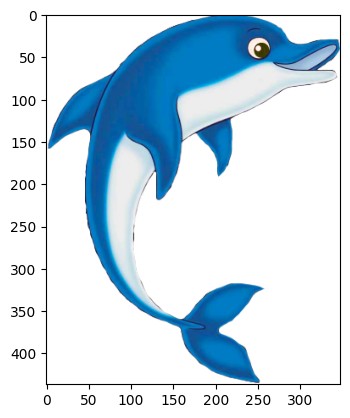

In [662]:
# Initialize random key
key = random.PRNGKey(28)

# Load and preview image normalized
# Separate color and alpha channel
img_rgba = jnp.array(plt.imread("dolphin_color.png"))
colors, mask = img_rgba[...,0:3], img_rgba[...,3].astype(bool)

# Define function to sample non transparent region of image
# when learning image
def sample_img(colors, mask, n_samples, key):
    
    # Extract n non-masked pixel coordinates (x) and colors (y)
    p_x, p_y = jnp.meshgrid(jnp.arange(img_rgba.shape[0]),jnp.arange(img_rgba.shape[1]), indexing='ij')
    p_x = jnp.stack((p_x, p_y),axis=-1)[mask]
    x = p_x[random.choice(random.split(key)[1], p_x.shape[0], (n_samples,))]
    y = colors[x[...,0], x[...,1]]
    x = x.at[...,0].divide(img_rgba.shape[0])
    x = x.at[...,1].divide(img_rgba.shape[1])

    return x, y

# Define function to sample non transparent region of image
# and subgroup based on image split mask for task 2 and 3
def sample_img_regions(colors, mask, n_samples, key, region_mask):
    
    # Extract n non-masked pixel coordinates (x) and colors (y)
    p_x, p_y = jnp.meshgrid(jnp.arange(img_rgba.shape[0]),jnp.arange(img_rgba.shape[1]), indexing='ij')

    # Pick random samples in both regions equally
    # We use the alpha mask from the image combined with the region mask 
    # to sample the assigned region of the dolphin for each of the both models
    n_samples = int(n_samples / 2)
    p1_coords = jnp.stack((p_x, p_y),axis=-1)[mask * region_mask]
    x1 = p1_coords[random.choice(random.split(key)[1], p1_coords.shape[0], (n_samples,))]
    p2_coords = jnp.stack((p_x, p_y),axis=-1)[mask * ~region_mask]
    x2 = p2_coords[random.choice(random.split(key)[1], p2_coords.shape[0], (n_samples,))]
    x = jnp.stack((x1, x2), axis=0)
    
    # Normalize coordinates and extract color labels
    y = colors[x[...,0], x[...,1]]
    x = x.at[...,0].divide(img_rgba.shape[0])
    x = x.at[...,1].divide(img_rgba.shape[1])

    return x, y

# Validate and display
print(f"Image intensity range: {jnp.min(img_rgba)} to {jnp.max(img_rgba)}")
plt.imshow(img_rgba)
print(f"Example sampling (Coordinates, Intensities): {sample_img(colors,mask, 3, key)}")

### #1 - MLP for one image
Fit a single MLP to an image.

Add helper functions

In [670]:
# Initalize parameters of network (weights and biases)
def init_mlp(layer_dims, key):
    p = []
    keys = random.split(key, len(layer_dims))
    for k, (n_in, n_out) in zip(keys, zip(layer_dims[:-1], layer_dims[1:])):
        W = random.normal(k, (n_in, n_out)) * 0.1
        b = jnp.zeros((n_out,))
        p.append((W, b))
    return p

# Predict with model
@jit
def forward(p, x):
    for W, b in p:
        x = jax.nn.leaky_relu(jnp.dot(x, W) + b, 0.01)
    return x

# Mean squared error loss function
@jit
def loss(p, x, y):
    preds = jax.vmap(lambda x: forward(p, x))(x)
    return jnp.mean((preds - y) ** 2)

# Display image comparison between learned and original
def display_comparison(p):
    # Generate full predicted image
    H, W, C = colors.shape
    coords = jnp.indices((H, W)).reshape(2,-1).T
    coords = coords.at[...,0].divide(W)
    coords = coords.at[...,1].divide(H)
    pred_colors = jnp.clip(jax.vmap(lambda x: forward(p, x))(coords).reshape(H, W, C),0,1)

    # Display original and predicted image
    ip.display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[0].imshow(img_rgba)
    ax[0].set_title("Original")
    ax[1].imshow(pred_colors)
    ax[1].set_title("Predicted")
    ax[2].imshow(jnp.concat([pred_colors, jnp.expand_dims(mask,axis=-1)], axis=-1))
    ax[2].set_title("Predicted Masked")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

Training Loop

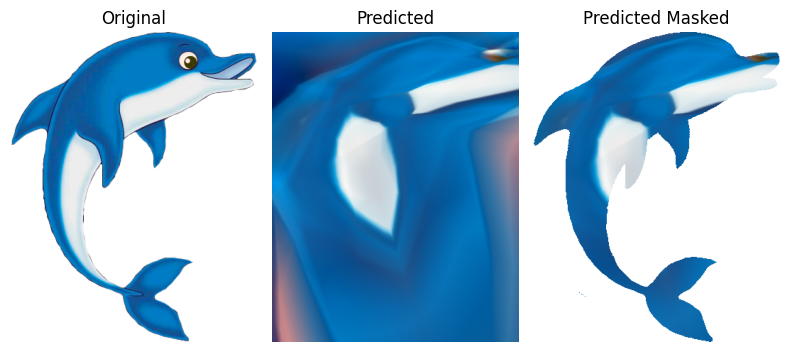

In [679]:
# Hyperparameter
p = init_mlp([2, 32, 32, 32, 32, 32, 32, 3], key)
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(p)
num_epochs = 2000
batch_size = 1024

# Just in time compiled update function for speed up training
@jit
def update(p, opt_state, x, y):
    grads = grad(loss)(p, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state

# Training loop
for epoch in range(num_epochs):
    x, y = sample_img(colors, mask, batch_size,key)
    p, opt_state = update(p, opt_state, x, y)
    if epoch % 100 == 0:
        ip.display.clear_output(wait=True)
        print(f"Epoch {epoch}, Loss: {loss(p, x, y)}")
        display_comparison(p)

### #2 - Two MLPs for one image
Fit two MLPs to a single image with a fixed split of the image into subregions to learn.

Split image into 2 regions and test region sampling.

Text(0.5, 1.0, 'Region 2 Samples')

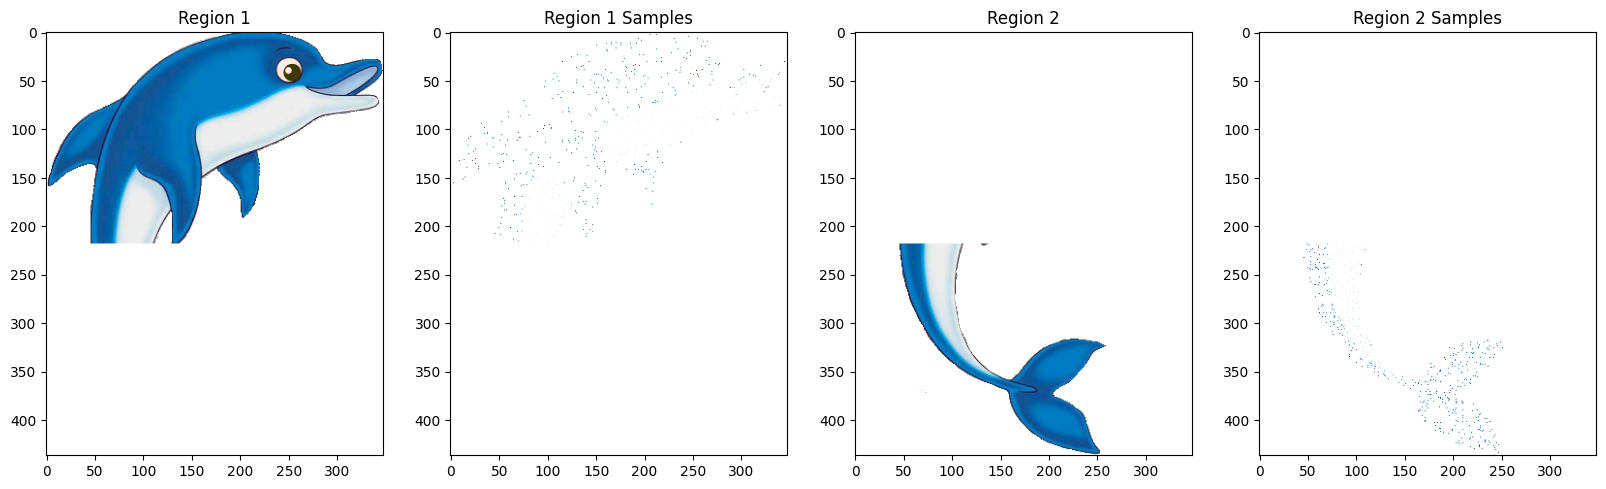

In [440]:
# Define image split using polyline
path = mp.path.Path(jnp.array([[0,-1],[img_rgba.shape[0]/2,-1],[img_rgba.shape[0]/2,img_rgba.shape[1]],[0,img_rgba.shape[1]],[0,-1]]))
xi, yi = jnp.indices((mask.shape[0], mask.shape[1]))
coords = jnp.stack((xi, yi), axis=-1)
region_mask = path.contains_points(coords.reshape(coords.shape[0]*coords.shape[1],2)).reshape(coords.shape[0],coords.shape[1],1)
mask_1 = region_mask * jnp.expand_dims(mask, axis=-1)
mask_2 = ~region_mask * jnp.expand_dims(mask, axis=-1)

# Test region sampling
def mask_for_model(x:jax.Array):
    mask1 = jnp.zeros_like(mask_1).at[(x[0,:,0]*img_rgba.shape[0]).astype(int), (x[0,:,1]*img_rgba.shape[1]).astype(int)].set(True)
    mask2 = jnp.zeros_like(mask_1).at[(x[1,:,0]*img_rgba.shape[0]).astype(int), (x[1,:,1]*img_rgba.shape[1]).astype(int)].set(True)
    return mask1, mask2
x, _ = sample_img_regions(colors, mask, batch_size, key, jnp.squeeze(mask_1))
sample_mask_1, sample_mask_2 = mask_for_model(x)

# Plot both regions
fig, ax = plt.subplots(1,4, figsize=(20,10))

ax[0].imshow(jnp.concat((colors,mask_1), axis=-1))
ax[0].set_title("Region 1")
ax[1].imshow(jnp.concat((colors,sample_mask_1), axis=-1))
ax[1].set_title("Region 1 Samples")
ax[2].imshow(jnp.concat((colors,mask_2), axis=-1))
ax[2].set_title("Region 2")
ax[3].imshow(jnp.concat((colors,sample_mask_2), axis=-1))
ax[3].set_title("Region 2 Samples")


Helper Functions

In [442]:
# Predict with model
def forward(p, x:jax.Array):
    for W, b in p:
        x = jax.nn.leaky_relu(jnp.dot(x, W) + b, 0.01)
    return x
    
# Mean squared error loss function
# The error is only counted from the model assigned to the queried region
def loss(p, x:jax.Array, y:jax.Array):
    # Loop through input based on assigned region to predict
    # with respetive model
    preds = []
    for i, (name, model) in enumerate(p.__dict__.items()):
        preds.append(jax.vmap(lambda x: forward(model, x))(x[i])) 
    preds = jnp.stack(preds,axis=0)
    
    return jnp.mean((preds - y) ** 2)

# Display image comparison between learned and original
def compare_image_region_predict(p):
    # Generate full predicted image
    ## Generate coordinates
    H, W, C = colors.shape
    coords = jnp.indices((H, W)).reshape(2,-1).T
    coords = coords.at[...,0].divide(H)
    coords = coords.at[...,1].divide(W)

    ## Pre-process input and assign to model regions
    ## Query pixels with respective model
    x = [coords[region_mask.flatten()], coords[~region_mask.flatten()]]
    preds = []
    for i, (name, model) in enumerate(p.__dict__.items()):
        preds.append(jax.vmap(lambda x: forward(model, x))(x[i])) 
    preds = jnp.concat(preds,axis=0)
    pred_colors = jnp.clip(preds.reshape( H, W, C),0,1)

    # Display original and predicted image
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(img_rgba)
    ax[0].set_title("Original")
    ax[1].imshow(pred_colors)
    ax[1].set_title("Output")
    ax[2].imshow(jnp.concat([pred_colors, mask.reshape(H,W, 1)], axis=-1))
    ax[2].set_title("Output Masked")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

Training loop

Epoch 19900, Loss: 0.0008029136806726456


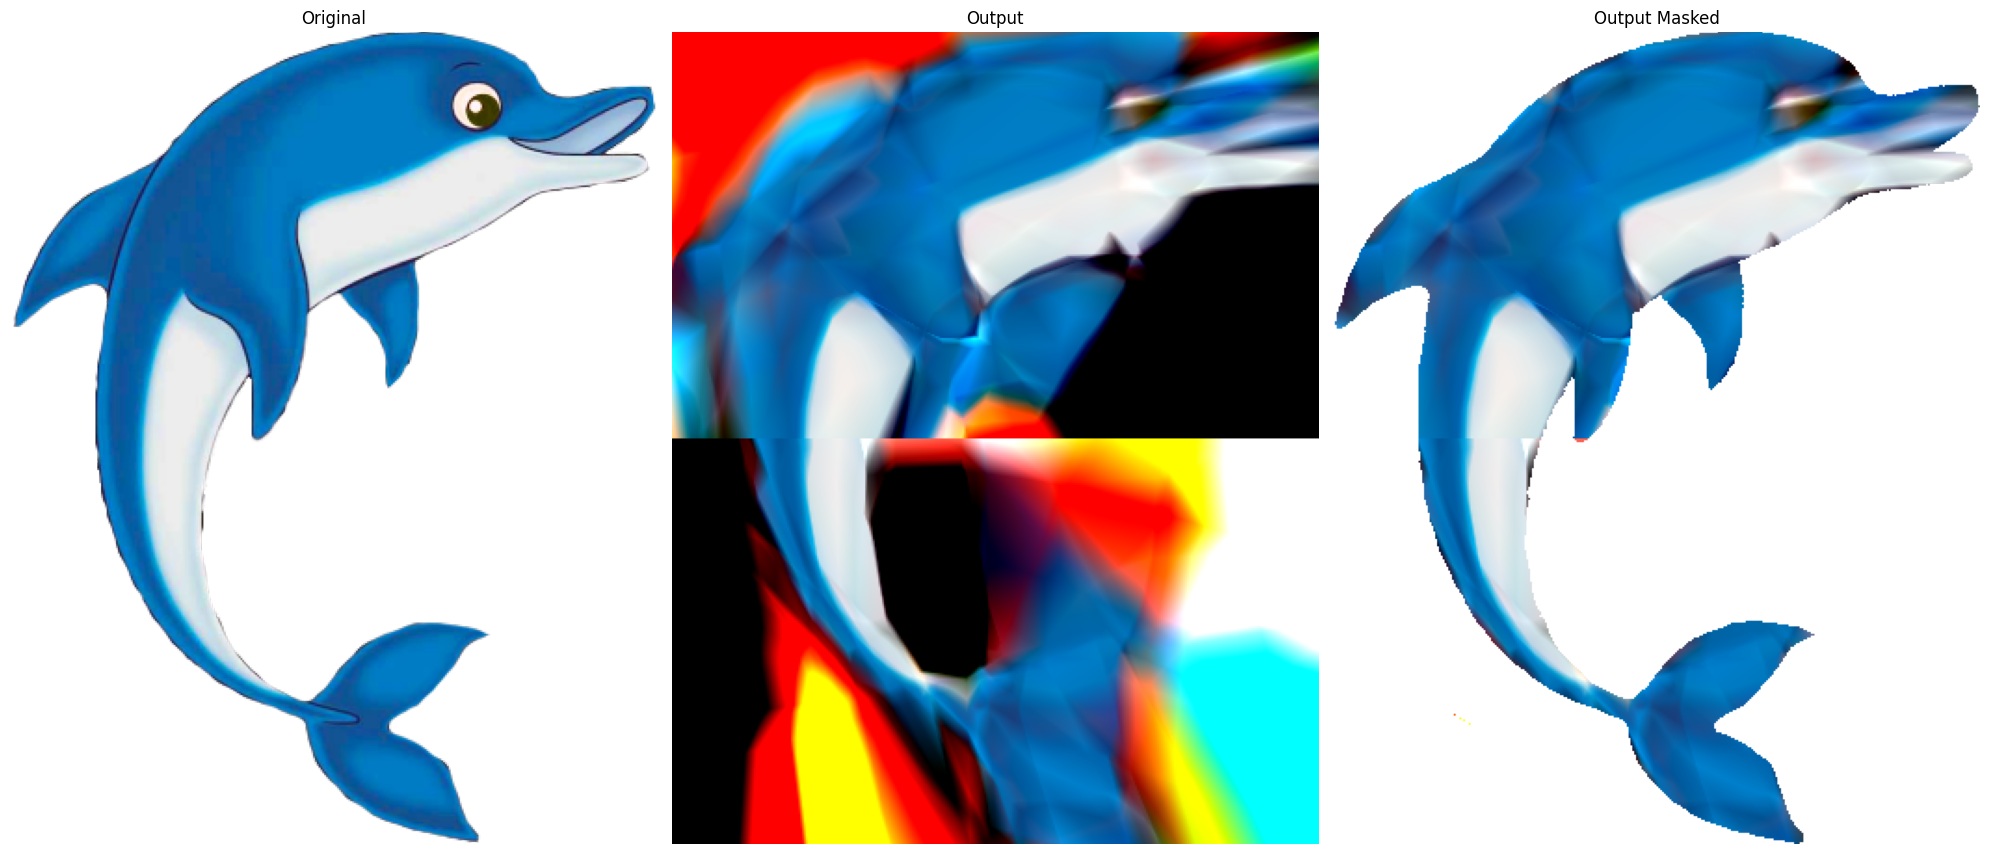

In [ ]:
# Hyperparameter
class Params(struct.PyTreeNode):
    model1: list
    model2: list
p = Params(
    model1=init_mlp([2, 64, 64, 64, 3], key), 
    model2=init_mlp([2, 64, 64, 64, 3], key)
)
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(p)
num_epochs = 20000
batch_size = 1024

# Just in time compiled update function for speed up training
@jit
def update(p:dict, opt_state, x:jax.Array, y:jax.Array):
    grads = grad(loss)(p, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state

# Training loop
for epoch in range(num_epochs):
    x, y = sample_img_regions(colors, mask, batch_size, key, jnp.squeeze(region_mask))
    p, opt_state = update(p, opt_state, x, y)
    if epoch % 100 == 0:
        ip.display.clear_output(wait=True)
        print(f"Epoch {epoch}, Loss: {loss(p, x, y)}")
        compare_image_region_predict(p)

### #4 - MoE for one image
Two MLP for one image, best split is result of clasifcying space using a network (~MoE)

Helper functions

0

In [660]:
# Forward through expert network
@jit
def forward_expert(expert_params, x):
    for W, b in expert_params:
        x = jax.nn.leaky_relu(jnp.dot(x, W) + b, 0.01)
    return x

# Forward through gate network
@jit
def forward_gate(params, x:jax.Array):
    x *= 100
    for W, b in params[:-1]:
        x = jax.nn.leaky_relu(jnp.dot(x, W) + b, 0.01)
    final_w, final_b = params[-1]
    x = jnp.dot(x, final_w) + final_b
    jax_key = random.PRNGKey(int(np.random.randint(0, 1e6))) # not ideal, but these jax random keys are a bit convoluted 
    x = jax.random.categorical(jax_key, x)
    return x

# Forward through model
@jit
def forward(params, x:jax.Array):
    # Gating
    gate = jax.vmap(lambda x: forward_gate(params.gate, x))(x)

    # Experting
    def expert0(x): return forward_expert(params.model1, x)
    def expert1(x): return forward_expert(params.model2, x)

    # Use `jax.lax.switch` to select and execute only the correct expert dynamically
    final_pred = jax.vmap(
        lambda idx, x: jax.lax.switch(idx, [expert0, expert1], x))(
            gate, x
    )
    return final_pred
    
# Mean squared error loss function
# The error is only counted from the model assigned to the queried region
@jit
def loss(params, x:jax.Array, y:jax.Array):
    preds = forward(params, x)
    return jnp.mean((preds - y) ** 2)

# Display image comparison between learned and original
def compare_image_region_predict(params:Params):
    # Generate coordinates
    H, W, C = colors.shape
    coords = jnp.indices((H, W)).reshape(2,-1).T
    coords = coords.at[...,0].divide(H)
    coords = coords.at[...,1].divide(W)

    # Generate full predicted image intensities
    pred_colors = forward(params, coords)
    pred_colors = jnp.clip(pred_colors.reshape( H, W, C),0,1)

    # Generate gating segmentation map
    @jit
    def get_gating(coords):return jax.vmap(lambda x: forward_gate(params.gate, x))(coords)
    segmentation_map = get_gating(coords).reshape( H, W, 1)

    # Display original and predicted image
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(img_rgba)
    ax[0].set_title("Original")
    ax[1].imshow(segmentation_map)
    ax[1].set_title("Gating Segmentation")
    ax[2].imshow(pred_colors)
    ax[2].set_title("Output")
    ax[3].imshow(jnp.concat([pred_colors, mask.reshape(H,W, 1)], axis=-1))
    ax[3].set_title("Output Masked")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

Traininig loop

Epoch 1900, Loss: 0.006781972013413906


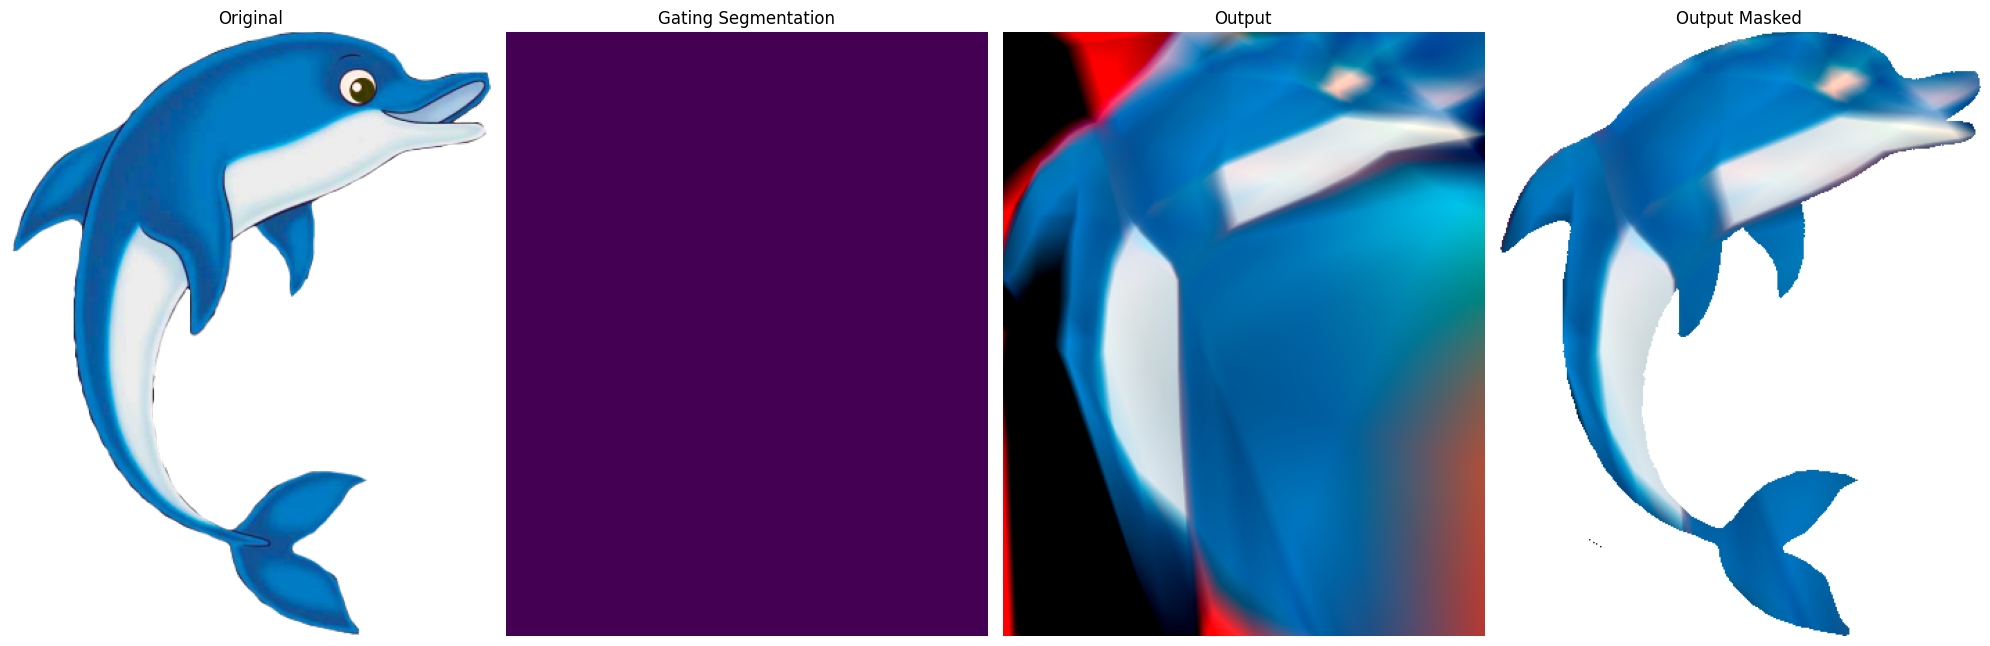

Plot computed in: 2.772719144821167s
Epoch 1901, Loss: 0.006394931580871344
Epoch 1902, Loss: 0.007299273274838924
Epoch 1903, Loss: 0.007575470954179764
Epoch 1904, Loss: 0.006984713952988386
Epoch 1905, Loss: 0.0067744990810751915
Epoch 1906, Loss: 0.006473526358604431
Epoch 1907, Loss: 0.006465718150138855
Epoch 1908, Loss: 0.0071139163337647915
Epoch 1909, Loss: 0.0074927653186023235
Epoch 1910, Loss: 0.007719916757196188
Epoch 1911, Loss: 0.0071240756660699844
Epoch 1912, Loss: 0.006457950454205275
Epoch 1913, Loss: 0.006346072070300579
Epoch 1914, Loss: 0.007065469399094582
Epoch 1915, Loss: 0.007736011408269405
Epoch 1916, Loss: 0.008022470399737358
Epoch 1917, Loss: 0.0067030503414571285
Epoch 1918, Loss: 0.0068999784998595715
Epoch 1919, Loss: 0.008188984356820583
Epoch 1920, Loss: 0.007034423761069775
Epoch 1921, Loss: 0.006442057900130749
Epoch 1922, Loss: 0.006341051310300827
Epoch 1923, Loss: 0.006913396529853344
Epoch 1924, Loss: 0.007474783807992935
Epoch 1925, Loss: 0.0

In [661]:
# Hyperparameter
class Params(struct.PyTreeNode):
    model1: list
    model2: list
    gate: list
params = Params(
    model1=init_mlp([2, 64, 64, 64, 3], key), 
    model2=init_mlp([2, 64, 64, 64, 3], key),
    gate=init_mlp([2, 5, 5, 5, 2], key)
)
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(params)
num_epochs = 2000
batch_size = 1024

# Just in time compiled update function for speed up training
@jit
def update(params, opt_state, x:jax.Array, y:jax.Array):
    grads = grad(loss)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# Training loop
for epoch in range(num_epochs):
    x, y = sample_img(colors, mask, batch_size, key)
    params, opt_state = update(params, opt_state, x, y)
    print(f"Epoch {epoch}, Loss: {loss(params, x, y)}")
    if epoch % 100 == 0:
        ip.display.clear_output(wait=True)
        print(f"Epoch {epoch}, Loss: {loss(params, x, y)}")
        s = time.time()
        compare_image_region_predict(params)
        print(f"Plot computed in: {time.time() - s}s")